In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import os
import pdb
from statistics import mean
from helpers.dataset import SequenceData
from helpers.seed import seed_dataloader, set_device, set_seed, get_generator
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
set_seed(10)
device = set_device()
print(device)

g_seed = get_generator(10)

Seed 10 has been set
cpu


Generate data

In [4]:
# x = torch.arange(0,32*np.pi, 0.1)
# y = torch.sin(2*x) + torch.randn(size = (len(x),))/2
# plt.figure()
# plt.plot(x.detach().numpy(),y.detach().numpy())
# plt.show()

In [5]:
# len(x)

In [6]:
# x = x.detach().numpy()
# y = y.detach().numpy()
# df = pd.DataFrame(data = {"x": x, "y": y})
# lagged_y = df["y"].shift(1)
# df["lagged_y"] = lagged_y
# df = df[1:]
# df.to_csv("data/less_perterbed_sin.csv")

In [7]:
# df.head()

In [8]:
# cut = int(len(df)*0.8//1)
# train_df = df[:cut]
# test_df = df[cut:]
# train_df.to_csv("data/train_less_perturbed_sin.csv", index = False)
# test_df.to_csv("data/test_less_perturbed_sin.csv", index = False)

In [3]:
cd = os.getcwd()

In [4]:
train_data = pd.read_csv(cd + "/data/train_less_perturbed_sin.csv", index_col = False)
test_data = pd.read_csv(cd + "/data/test_less_perturbed_sin.csv", index_col = False)

In [5]:
y_col = "y"
x_cols = list(train_data.columns.drop(["y"]))
print(x_cols)
training = SequenceData(y_col, x_cols, 62, data_path =  cd + "/data/train_less_perturbed_sin.csv") # batch size 62, should be amount to get to 2pi cycle
testing = SequenceData(y_col, x_cols, 62, data_path = cd + "/data/test_less_perturbed_sin.csv")  

['x', 'lagged_y']


In [16]:
train_loader = DataLoader(training, shuffle = False, worker_init_fn = seed_dataloader, generator = g_seed)
test_loader = DataLoader(testing, shuffle = False, worker_init_fn = seed_dataloader, generator = g_seed)

In [7]:
device

device(type='cpu')

MODEL CLASS/HYPER PARAMETERS

In [9]:
class LSTM2(nn.Module):

    def __init__(self, num_hidden, num_features, out_features, num_layers, dropout, batch_first = True):
        super().__init__()
        self.num_sensors = num_features
        self.num_hidden = num_hidden
        self.out_features = out_features
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = num_features, hidden_size = num_hidden, batch_first = batch_first, num_layers = num_layers, dropout = dropout)
        self.linear = nn.Linear(in_features = self.num_hidden, out_features = out_features)

    def forward(self, X):
        batch_size = X.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.num_hidden).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.num_hidden).requires_grad_().to(device)

        out, (hn,cn) = self.lstm(X, (h0, c0))
        output = self.linear(hn[0]).flatten()

        return output

def train(training_data, model, loss, optimizer):
    # training for one epoch
    model.train()
    total = 0
    actuals = []
    pred = []
    for i, batch in enumerate(training_data):
        X,y = batch
        # X = X.permute(1,0,2) do this if batch_first = False
        X,y = X.to(device), y.to(device)
        output = model(X)
        ls = loss(output, y)

        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
        total += ls.item()  

        actuals.append(y)
        pred.append(output)

    mean_loss = total/len(training_data)
    print(f"Average training loss is {mean_loss}")

    return actuals, pred, mean_loss

def test(testing_data, model, loss):
    # testing for one epoch
    model.eval()
    actuals, pred = [], []
    total = 0

    with torch.no_grad():
        for i, batch in enumerate(testing_data):
            X,y = batch
            # X = X.permute(1,0,2) do this if batch_first = False
            X,y = X.to(device), y.to(device)
            output = model(X)
            ls = loss(output, y)
            actuals.append(y[0].cpu().detach().numpy())
            pred.append(output[0].cpu().detach().numpy())

            total += ls.item()

    mean_loss = total/len(testing_data)
    print(f"Average testing loss is {mean_loss}")
    return actuals, pred, mean_loss

In [ ]:
# hyperparameters
lr = 10**(-4)
num_features = len(x_cols)
out_features = 1

num_layers = 2
num_hidden = 32
epochs = 2000
dropout = 0.2
early_stop_val = 1

model1 = LSTM2(num_hidden, num_features, out_features, num_layers, dropout).to(device)

optimizer = torch.optim.Adam(params = model1.parameters(), lr = lr)
loss = nn.MSELoss()

val_loss_info = {}
val_loss = []
training_loss = []
early_stop = 0
prev_mean_loss = 1
num_epochs = 0
for i in range(epochs):
    print(f"Epoch {i}")
    t_actuals, t_preds, train_loss = train(train_loader, model1, loss, optimizer)
    actuals, preds, mean_loss = test(test_loader, model1, loss)
    val_loss_info[i] = [actuals, preds]
    val_loss.append(mean_loss)
    training_loss.append(train_loss)
    if mean_loss > prev_mean_loss:
        early_stop += 1
    else:
        early_stop = 0

    prev_mean_loss = mean_loss

    if early_stop >= early_stop_val:
        num_epochs = i
        print(f"Validation Error has increased for {early_stop_val} iterations straight. Stopping at iteration {i}")
        break
    num_epochs = i
    print("\n")

torch.save(model1, f"lstm_trained_epoch{i}_{loss}_lr_{lr}")

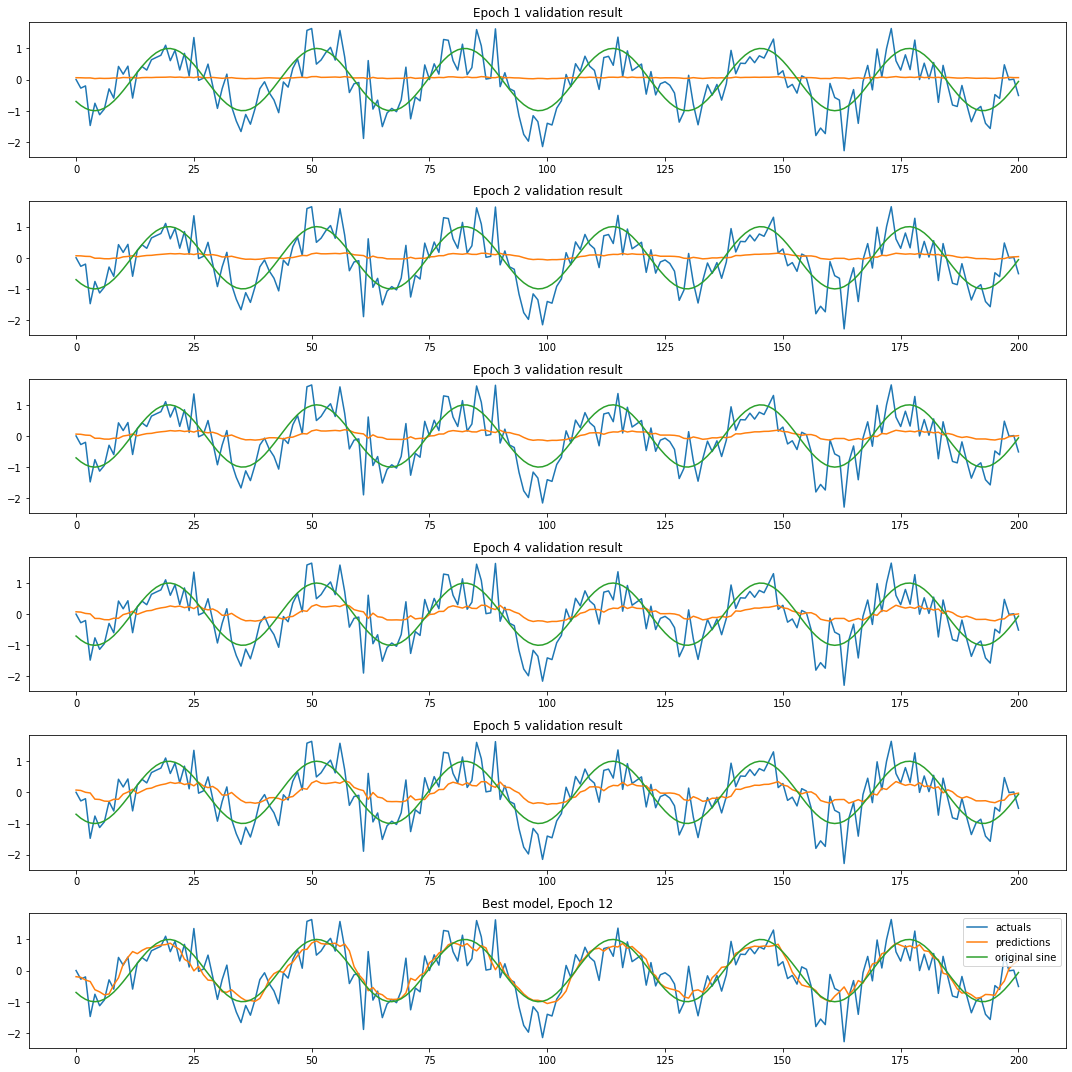

In [28]:
fig, ax = plt.subplots(6,1, figsize = (15,15))
minimum = min(val_loss)
minind = [i for i, val in enumerate(val_loss) if val == minimum]
mult = num_epochs//5 - 1

# for plotting the original, non perturbed sine wave
x = torch.Tensor(test_data["x"].to_numpy())
y = torch.sin(2*x)

for i in range(5):
    ind = (i+1)*mult
    ax[i].plot(val_loss_info[ind][0], label = "actuals")
    ax[i].plot(val_loss_info[ind][1], label = "predicted")
    ax[i].plot(y, label = "original sine")

    ax[i].set_title(f"Epoch {ind} validation result")

ax[5].plot(val_loss_info[minind[0]][0], label = "actuals")
ax[5].plot(val_loss_info[minind[0]][1], label = "predictions")
ax[5].plot(y, label = "original sine")
ax[5].set_title(f"Best model, Epoch {minind[0]}")
plt.legend()
fig.tight_layout()
plt.savefig("preds_vs_vals.png", bbox_inches = "tight")

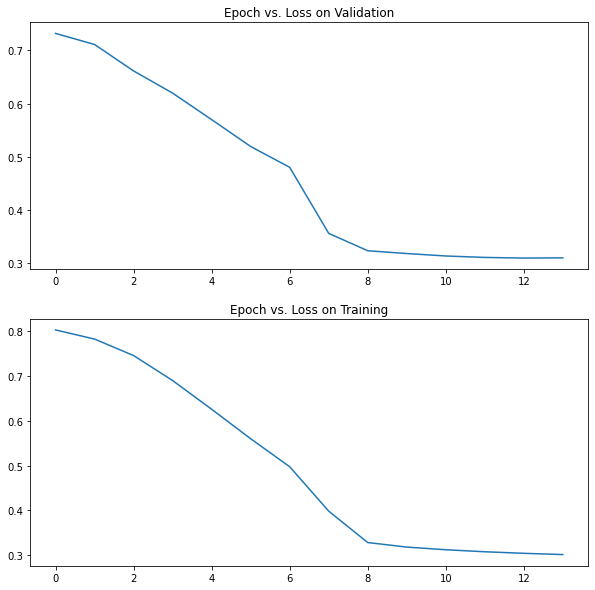

In [25]:
xval = range(len(val_loss))
xtrain = range(len(training_loss))
fig, ax = plt.subplots(nrows = 2, figsize = (10,10))
ax[0].plot(xval, val_loss, label = "Val Loss")
ax[0].set_title("Epoch vs. Loss on Validation")
ax[1].plot(xtrain, training_loss, label = "Train Loss" )
ax[1].set_title("Epoch vs. Loss on Training")
fig.get_constrained_layout()
plt.savefig("epoch_vs_loss.png", bbox_inches = "tight")

In [10]:
model = torch.load("lstm_on_smoother_sine/lstm_trained_epoch13_MSELoss()_lr_0.0001", map_location = torch.device("cpu"))

In [11]:
print(model)

LSTM2(
  (lstm): LSTM(2, 32, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
from torchviz import make_dot

In [15]:
batch = next(iter(train_loader))
x,y = batch
yhat = model(x)
make_dot(yhat, params=dict(model.named_parameters())).render("rnn_torchviz", format="png")

KeyboardInterrupt: 

In [18]:
print(minimum)

NameError: name 'minimum' is not defined